# 데이터 셋

* 데이터 출처 : kaggle의 olist sellers dataset을 사용했습니다 
  * url : https://www.kaggle.com/olistbr/brazilian-ecommerce?select=olist_sellers_dataset.csv

# 분석 목표 
* 현재 상황을 파악하여 매출 개선 계획 
* 2023년 프로모션 진행은 언제, 어느 카테고리에서 진행하는 것이 좋을까?

-----
가설 : 
* 우리 서비스의 매출 상황은 점점 성장하고 있을 것이다.
    * 전체적인 구매자 수가 증가했다
    * ARPPU가 증가했다
    * 장바구니 크기가 증가했다
    * 연간 구입 건수가 증가했다

* 분기별 매출에서는 4분기 매출이 가장 높을 것이다.
    * 연말과 블랙 프라이데이가 집중되어 있는 4분기 매출이 가장 높을 것.

* 주말보다 평일에서의 매출이 더 많이 나올 것이다 
    * 주말에는 외부 활동이 많아지기 때문에 평일에 구매가 더 많이 일어날 것

# 데이터 정제 

## 분석 시 필요한 라이브러리 

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from matplotlib import style 
import seaborn as sns
from datetime import datetime,timedelta
import warnings 
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.simplefilter("ignore")
pd.set_option('display.max_columns', 100)

import gc 
import itertools 

In [2]:
# initiate visualization library for jupyter notebook 
# defining visualization functions 

# 축 설정 
def format_spines(ax, right_border = True):
    
    ax.spines['bottom'].set_color('#666666') # 회색 선 
    ax.spines['left'].set_color('#666666')
    ax.spines['top'].set_visible(False) # top 선은 안가지기 
    if right_border:
        ax.spines['right'].set_color('#FFFFFF') # 흰색 처리
    else:
        ax.spines['right'].set_color('#FFFFFF')
    ax.patch.set_facecolor('#FFFFFF') # 배경색 흰색으로 처리 

def count_plot(feature, df, colors='Blues_d', hue=False, ax=None, title=''):
    
    # Preparing variables
    ncount = len(df)
    if hue != False:
        ax = sns.countplot(x=feature, data=df, palette=colors, hue=hue, ax=ax)
    else:
        ax = sns.countplot(x=feature, data=df, palette=colors, ax=ax)
        
    format_spines(ax)

    # Setting percentage
    for p in ax.patches:
        x=p.get_bbox().get_points()[:,0]
        y=p.get_bbox().get_points()[1,1]
        ax.annotate('{:.1f}%'.format(100.*y/ncount), (x.mean(), y), 
                ha='center', va='bottom') # set the alignment of the text
    
    # Final configuration
    if not hue:
        ax.set_title(df[feature].describe().name + ' Analysis', size=13, pad=15)
    else:
        ax.set_title(df[feature].describe().name + ' Analysis by ' + hue, size=13, pad=15)  
    if title != '':
        ax.set_title(title)       
    plt.tight_layout()
    
    
# bar plot 
def bar_plot(x, y, df, colors = 'Blues_d', hue=False, ax=None, value=False, title=''):
    
    # preparing variables 
    try: 
        ncount = sum(df[y])
    except:
        ncount = sum(df[x])
    
    #fig, ax = plt.subplots()
    if hue != False:
        ax = sns.barplot(x=x, y=y, data=df, palette=colors, hue=hue, ax=ax, ci=None)
    else:
        ax = sns.barplot(x=x, y=y, data=df, palette=colors, ax=ax, ci=None)
        
    # setting borders
    format_spines(ax)
    
    # Setting percentage
    for p in ax.patches:
        xp=p.get_bbox().get_points()[:,0]
        yp=p.get_bbox().get_points()[1,1]
        if value:
            ax.annotate('{:.2f}k'.format(yp/1000), (xp.mean(), yp), 
                    ha='center', va='bottom') # set the alignment of the text
        else:
            ax.annotate('{:.1f}%'.format(100.*yp/ncount), (xp.mean(), yp), 
                    ha='center', va='bottom') # set the alignment of the text
    if not hue:
        ax.set_title(df[x].describe().name + ' Analysis', size=12, pad=15)
    else:
        ax.set_title(df[x].describe().name + ' Analysis by ' + hue, size=12, pad=15)
    if title != '':
        ax.set_title(title)  
    plt.tight_layout()

## 데이터 불러오기 


In [3]:
customers = pd.read_csv("c:/data/olist/olist_customers_dataset.csv")
order_items = pd.read_csv('c:/data/olist/olist_order_items_dataset.csv')
order_payments = pd.read_csv("c:/data/olist/olist_order_payments_dataset.csv")
products = pd.read_csv('c:/data/olist/olist_products_dataset.csv')
category_translation = pd.read_csv("c:/data/olist/product_category_name_translation.csv")
orders = pd.read_csv('c:/data/olist/olist_orders_dataset.csv')
translation = pd.read_csv('c:/data/olist/product_category_name_translation.csv')

In [4]:
# displaying data shape 
dataset = {
    'Customers' : customers,
    'Order Items' : order_items,
    'Payments' : order_payments, 
    'Orders' : orders,
    'Products' : products,
    'Translation' : category_translation
}

# x(총 row수), y(컬럼 수)
for x,y in dataset.items():
    print(f'{x}', (list(y.shape)))

Customers [99441, 5]
Order Items [112650, 7]
Payments [103886, 5]
Orders [99441, 8]
Products [32951, 9]
Translation [71, 2]


In [5]:
# displaying dataset column names 
for x, y in dataset.items():
    print(f'{x}', f'{list(y.columns)}\n')

Customers ['customer_id', 'customer_unique_id', 'customer_zip_code_prefix', 'customer_city', 'customer_state']

Order Items ['order_id', 'order_item_id', 'product_id', 'seller_id', 'shipping_limit_date', 'price', 'freight_value']

Payments ['order_id', 'payment_sequential', 'payment_type', 'payment_installments', 'payment_value']

Orders ['order_id', 'customer_id', 'order_status', 'order_purchase_timestamp', 'order_approved_at', 'order_delivered_carrier_date', 'order_delivered_customer_date', 'order_estimated_delivery_date']

Products ['product_id', 'product_category_name', 'product_name_lenght', 'product_description_lenght', 'product_photos_qty', 'product_weight_g', 'product_length_cm', 'product_height_cm', 'product_width_cm']

Translation ['product_category_name', 'product_category_name_english']



In [6]:
# checking for null values in dataset 
for x, y in dataset.items():
    print(f'{x}: {y.isnull().any().any()}')

Customers: False
Order Items: False
Payments: False
Orders: True
Products: True
Translation: False


In [7]:
# taking count for dataset with missing values 
for x, y in dataset.items():
    if y.isnull().any().any():
        print(f'{x}', (list(y.shape)),'\n')
        print(f'{y.isnull().sum()}\n')

Orders [99441, 8] 

order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
order_estimated_delivery_date       0
dtype: int64

Products [32951, 9] 

product_id                      0
product_category_name         610
product_name_lenght           610
product_description_lenght    610
product_photos_qty            610
product_weight_g                2
product_length_cm               2
product_height_cm               2
product_width_cm                2
dtype: int64



## creating master dataframe 

**분석의 편의성을 위해 결측치는 drop 처리 하였습니다.** 

### Translate Product Name Into English

In [8]:
products_en = pd.merge(products, category_translation, how = 'outer', on = 'product_category_name')
products_en

,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,product_category_name_english
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumaria,40.0,287.0,1.0,225.0,16.0,10.0,14.0,perfumery
1,6a2fb4dd53d2cdb88e0432f1284a004c,perfumaria,39.0,346.0,2.0,400.0,27.0,5.0,20.0,perfumery
2,0d009643171aee696f4733340bc2fdd0,perfumaria,52.0,150.0,1.0,422.0,21.0,16.0,18.0,perfumery
3,b1eae565a61935e0011ee7682fef9dc9,perfumaria,49.0,460.0,2.0,267.0,17.0,13.0,17.0,perfumery
4,8da90b37f0fb171b4877c124f965b1f6,perfumaria,56.0,733.0,3.0,377.0,18.0,13.0,15.0,perfumery
...,...,...,...,...,...,...,...,...,...,...
32946,13b25797ad1e6d6c7cd3cbeb35f8ee7a,moveis_colchao_e_estofado,44.0,348.0,1.0,18250.0,25.0,25.0,25.0,furniture_mattress_and_upholstery
32947,dc36a7859b743d8610a2bbbaea26ece9,moveis_colchao_e_estofado,29.0,2073.0,2.0,2500.0,41.0,21.0,21.0,furniture_mattress_and_upholstery
32948,107fde0930956120d1e13dd1062fbb46,moveis_colchao_e_estofado,51.0,418.0,1.0,30000.0,60.0,73.0,60.0,furniture_mattress_and_upholstery
32949,726b4e18f00255e2e63491bcba3f60b8,moveis_colchao_e_estofado,41.0,866.0,1.0,1700.0,70.0,10.0,100.0,furniture_mattress_and_upholstery


In [9]:
# 어떤 카테고리의 제품 이름이 번역되지 않았는지 찾아봅니다. 
set(products['product_category_name'].unique()) - set(category_translation['product_category_name'].unique())

{nan, 'pc_gamer', 'portateis_cozinha_e_preparadores_de_alimentos'}

In [10]:
# 번역되지 않은 카테고리는 수기로 변경함 
products_en['product_category_name_english'][products_en['product_category_name'] == 'pc_gamer'] = 'pc_gamer'
products_en['product_category_name_english'][products_en['product_category_name'] == 'portateis_cozinha_e_preparadores_de_alimentos'] = 'portable_kitchen_and_food_preparation'
products_en['product_category_name_english'][products_en['product_category_name'] == 'nan'] = 'unclassified'

In [11]:
# copy해두기 
products = products_en.copy()

### merge dataset 

In [12]:
# creating master dataframe 
df = pd.merge(orders, order_items, on = 'order_id', how = 'outer')
df = pd.merge(df, order_payments, on = 'order_id', how = 'outer')
df = pd.merge(df, products, on = 'product_id', how = 'outer')
df = pd.merge(df, customers, on = 'customer_id', how = 'outer')
print(df.shape)

(118434, 31)


### converting data columns to datetime

In [13]:
# converting date columns to datetime
date_columns = ['shipping_limit_date', 'order_purchase_timestamp', 'order_approved_at', 'order_delivered_carrier_date', 'order_delivered_customer_date', 'order_estimated_delivery_date']
for col in date_columns:
    df[col] = pd.to_datetime(df[col], format='%Y-%m-%d %H:%M:%S')

## Preprocessing Some columns

### cleaning up name columns

In [14]:
df['customer_city'] = df['customer_city'].str.title() # 대문자 변경 | 보기 쉬워짐
df['payment_type'] = df['payment_type'].str.replace('_',' ').str.title() #언더바를 띄어쓰기로 변환

df[['customer_city','payment_type']]

,customer_city,payment_type
0,Sao Paulo,Credit Card
1,Sao Paulo,Voucher
2,Sao Paulo,Voucher
3,Sao Paulo,Credit Card
4,Sao Paulo,Credit Card
...,...,...
118429,Sao Paulo,Credit Card
118430,Sao Paulo,Credit Card
118431,Campo Do Tenente,Credit Card
118432,Sao Jose Dos Campos,Credit Card


### engineering new/essential columns

In [15]:
# 예상 배송일 
df['delivery_against_estimated'] = (df['order_estimated_delivery_date'] - df['order_delivered_customer_date']).dt.days

In [16]:
# 구매 년도를 새로운 컬럼으로 변경
df['order_purchase_year'] = df['order_purchase_timestamp'].apply(lambda x : x.year)

In [17]:
# 구매 분기
df['order_purchase_quarter'] = df['order_purchase_timestamp'].apply(lambda x : x.quarter)

In [18]:
# 구매 달 
df['order_purchase_month'] = df['order_purchase_timestamp'].apply(lambda x : x.month)

In [19]:
# 구매 주 
df['order_purchase_dayofweek'] = df['order_purchase_timestamp'].apply(lambda x : x.dayofweek)

In [20]:
# 구매 hour 
df['order_purchase_hour'] = df['order_purchase_timestamp'].apply(lambda x : x.hour)

In [21]:
# 구매 데이 
df['order_purchase_day'] = df['order_purchase_dayofweek'].map({0:'Mon',1:'Tue',2:'Wed',3:'Thu',4:'Fri',5:'Sat',6:'Sun'})

### changing the month attribute for correct ordenation 

In [22]:
# 기존 월은 1~12로 구성되어 있음. 
df['order_purchase_month']

0         10
1         10
2         10
3          8
4          8
          ..
118429     8
118430     8
118431    12
118432     3
118433     3
Name: order_purchase_month, Length: 118434, dtype: int64

In [23]:
# 01~12로 나타내기 위해서 작업
df['order_purchase_month'] = df['order_purchase_month'].astype(str).apply(lambda x : '0'+x if len(x) == 1 else x)

### creating year_month column 

In [24]:
# 년-월 이어붙이기 
df['month_year'] = df['order_purchase_year'].astype(str) + '-' + df['order_purchase_month'].astype(str)
df['month_year']

0         2017-10
1         2017-10
2         2017-10
3         2017-08
4         2017-08
           ...   
118429    2017-08
118430    2017-08
118431    2017-12
118432    2017-03
118433    2018-03
Name: month_year, Length: 118434, dtype: object

In [25]:
df['month_y'] = df['order_purchase_timestamp'].map(lambda date : 100*date.year + date.month)
df['month_y']

0         201710
1         201710
2         201710
3         201708
4         201708
           ...  
118429    201708
118430    201708
118431    201712
118432    201703
118433    201803
Name: month_y, Length: 118434, dtype: int64

## 데이터 확인하기 및 추가 전처리

In [26]:
# displaying summary staticstics of columns
df.describe(include='all')

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,payment_sequential,payment_type,payment_installments,payment_value,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,product_category_name_english,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,delivery_against_estimated,order_purchase_year,order_purchase_quarter,order_purchase_month,order_purchase_dayofweek,order_purchase_hour,order_purchase_day,month_year,month_y
count,118434,118434,118434,118434,118258,116360,115037,118434,117604.000000,117604,117604,117604,117604.000000,117604.000000,118431.000000,118431,118431.000000,118431.000000,115906,115906.000000,115906.000000,115906.000000,117584.000000,117584.000000,117584.00000,117584.000000,115906,118434,118434.000000,118434,118434,115037.000000,118434.000000,118434.000000,118434,118434.000000,118434.00000,118434,118434,118434.000000
unique,99441,99441,8,98875,90733,81018,95664,459,NaN,32951,3095,93318,NaN,NaN,NaN,5,NaN,NaN,73,NaN,NaN,NaN,NaN,NaN,NaN,NaN,73,96096,NaN,4119,27,NaN,NaN,NaN,12,NaN,NaN,7,25,NaN
top,895ab968e7bb0d5659d16cd74cd1650c,270c23a11d024a44c896d1894b261a83,delivered,2017-08-08 20:26:31,2017-08-08 20:43:31,2017-08-10 11:58:14,2017-08-14 12:46:18,2017-12-20 00:00:00,NaN,aca2eb7d00ea1a7b8ebd4e68314663af,4a3ca9315b744ce9f8e9374361493884,2017-08-14 20:43:31,NaN,NaN,NaN,Credit Card,NaN,NaN,cama_mesa_banho,NaN,NaN,NaN,NaN,NaN,NaN,NaN,bed_bath_table,9a736b248f67d166d2fbb006bcb877c3,NaN,Sao Paulo,SP,NaN,NaN,NaN,08,NaN,NaN,Mon,2017-11,NaN
freq,63,63,115038,63,63,63,63,656,NaN,536,2133,63,NaN,NaN,NaN,87286,NaN,NaN,11823,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11823,75,NaN,18738,49967,NaN,NaN,NaN,12745,NaN,NaN,19262,9111,NaN
first,NaN,NaN,NaN,2016-09-04 21:15:19,2016-09-15 12:16:38,2016-10-08 10:34:01,2016-10-11 13:46:32,2016-09-30 00:00:00,NaN,NaN,NaN,2016-09-19 00:15:34,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
last,NaN,NaN,NaN,2018-10-17 17:30:18,2018-09-03 17:40:06,2018-09-11 19:48:28,2018-10-17 13:22:46,2018-11-12 00:00:00,NaN,NaN,NaN,2020-04-09 22:35:08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.195920,NaN,NaN,NaN,120.822849,20.045551,1.094207,NaN,2.937398,172.849395,NaN,48.767208,786.957302,2.207849,2114.281067,30.256872,16.63029,23.068394,NaN,NaN,35034.264392,NaN,NaN,11.042073,2017.536324,2.356536,NaN,2.745056,14.75605,NaN,NaN,201759.666126
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.697721,NaN,NaN,NaN,184.477367,15.861351,0.728290,NaN,2.774164,268.259831,NaN,10.035162,653.029009,1.719519,3788.754048,16.190874,13.45878,11.748372,NaN,NaN,29819.290218,NaN,NaN,10.165136,0.505492,1.062274,NaN,1.960629,5.32724,NaN,NaN,48.843291
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,0.850000,0.000000,1.000000,NaN,0.000000,0.000000,NaN,5.000000,4.000000,1.000000,0.000000,7.000000,2.00000,6.000000,NaN,NaN,1003.000000,NaN,NaN,-189.000000,2016.000000,1.000000,NaN,0.000000,0.00000,NaN,NaN,201609.000000
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,39.900000,13.080000,1.000000,NaN,1.000000,60.860000,NaN,42.000000,347.000000,1.000000,300.000000,18.000000,8.00000,15.000000,NaN,NaN,11310.000000,NaN,NaN,6.000000,2017.000000,1.000000,NaN,1.000000,11.00000,NaN,NaN,201709.000000


In [27]:
# displaying missing value counts and corresponding percentage against total observations 

missing_values = df.isnull().sum().sort_values(ascending = False)
percentage = (df.isnull().sum()/df.isnull().count()*100).sort_values(ascending = False)
pd.concat([missing_values,percentage],axis=1,keys = ['Values','Percentage']).transpose()

,order_delivered_customer_date,delivery_against_estimated,product_description_lenght,product_photos_qty,product_name_lenght,product_category_name,product_category_name_english,order_delivered_carrier_date,product_height_cm,product_length_cm,product_width_cm,product_weight_g,order_item_id,seller_id,shipping_limit_date,price,freight_value,product_id,order_approved_at,payment_type,payment_value,payment_installments,payment_sequential,order_purchase_dayofweek,order_purchase_hour,order_purchase_day,month_year,order_purchase_month,order_purchase_quarter,order_purchase_year,order_id,customer_state,customer_city,customer_zip_code_prefix,customer_unique_id,customer_id,order_estimated_delivery_date,order_purchase_timestamp,order_status,month_y
Values,3397.000000,3397.000000,2528.000000,2528.000000,2528.000000,2528.000000,2528.000000,2074.000000,850.000000,850.000000,850.000000,850.000000,830.000000,830.000000,830.000000,830.000000,830.000000,830.000000,176.000000,3.000000,3.000000,3.000000,3.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Percentage,2.868264,2.868264,2.134522,2.134522,2.134522,2.134522,2.134522,1.751186,0.717699,0.717699,0.717699,0.717699,0.700812,0.700812,0.700812,0.700812,0.700812,0.700812,0.148606,0.002533,0.002533,0.002533,0.002533,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


가장 많은 결측치 값을 가지고 있는게 order_delivered_customer_date 입니다. 
본 분석에서는 분석의 용이함을 위해 null 값을 모두 drop 하겠습니다.

In [28]:
# dropping missing values 
df.dropna(inplace = True)
df.isnull().values.any()

False

In [29]:
# displaying dataframe info
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 113390 entries, 0 to 118433
Data columns (total 40 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   order_id                       113390 non-null  object        
 1   customer_id                    113390 non-null  object        
 2   order_status                   113390 non-null  object        
 3   order_purchase_timestamp       113390 non-null  datetime64[ns]
 4   order_approved_at              113390 non-null  datetime64[ns]
 5   order_delivered_carrier_date   113390 non-null  datetime64[ns]
 6   order_delivered_customer_date  113390 non-null  datetime64[ns]
 7   order_estimated_delivery_date  113390 non-null  datetime64[ns]
 8   order_item_id                  113390 non-null  float64       
 9   product_id                     113390 non-null  object        
 10  seller_id                      113390 non-null  object        
 11  

**excluding incomplete 2012 data and displaying first 3 rows of master dataframe**

In [30]:
# 2016년 데이터는 완전하지 않음을 파악됨. 
df['month_year'].sort_values().unique()

array(['2016-10', '2016-12', '2017-01', '2017-02', '2017-03', '2017-04',
       '2017-05', '2017-06', '2017-07', '2017-08', '2017-09', '2017-10',
       '2017-11', '2017-12', '2018-01', '2018-02', '2018-03', '2018-04',
       '2018-05', '2018-06', '2018-07', '2018-08'], dtype=object)

In [31]:
df = df.query("month_year != '2016-10' and month_year != '2016-12'")

In [32]:
df['month_year'].sort_values().unique()

array(['2017-01', '2017-02', '2017-03', '2017-04', '2017-05', '2017-06',
       '2017-07', '2017-08', '2017-09', '2017-10', '2017-11', '2017-12',
       '2018-01', '2018-02', '2018-03', '2018-04', '2018-05', '2018-06',
       '2018-07', '2018-08'], dtype=object)

마스터 데이터 프레임은 고유 키를 통해 결합되어 제공되는 다양한 독립 데이터 세트로 구성됩니다. 날짜 열은 분석 목적으로 설계된 날짜/시간 및 새로운 필수 열로 변환되었습니다. 

# 가설 검증

## Revenue Part

### Total Sales 

In [33]:
df['payment_value'].sum()

19467987.99

### Monthly Revenue 

In [34]:
# calculate Revenue for each row and create a new dataframe with YearMonth - Revenue columns
# reset_index() : 행 인덱스 초기화 
df_revenue = df.groupby(['month_year'])['payment_value'].sum().reset_index()
df_revenue 

,month_year,payment_value
0,2017-01,172487.07
1,2017-02,313470.32
2,2017-03,496731.66
3,2017-04,444457.76
4,2017-05,687145.80
5,2017-06,577595.09
6,2017-07,711168.83
7,2017-08,835079.65
8,2017-09,985552.70
9,2017-10,972010.21


### Monthly Revenue Growth Rate 

In [35]:
# calculating for monthly revenue growth rate 
# using pct_change() function to see monthly percentage change 
# pct_change : 한 객체 내에서 행과 행의 차이를 현재값과 백분율로 출력하는 메서드
## (다음행-현재행) % 현재행 
df_revenue['MonthlyGrowth'] = df_revenue['payment_value'].pct_change()
df_revenue

,month_year,payment_value,MonthlyGrowth
0,2017-01,172487.07,NaN
1,2017-02,313470.32,0.817355
2,2017-03,496731.66,0.584621
3,2017-04,444457.76,-0.105236
4,2017-05,687145.80,0.546032
5,2017-06,577595.09,-0.159429
6,2017-07,711168.83,0.231258
7,2017-08,835079.65,0.174235
8,2017-09,985552.70,0.180190
9,2017-10,972010.21,-0.013741


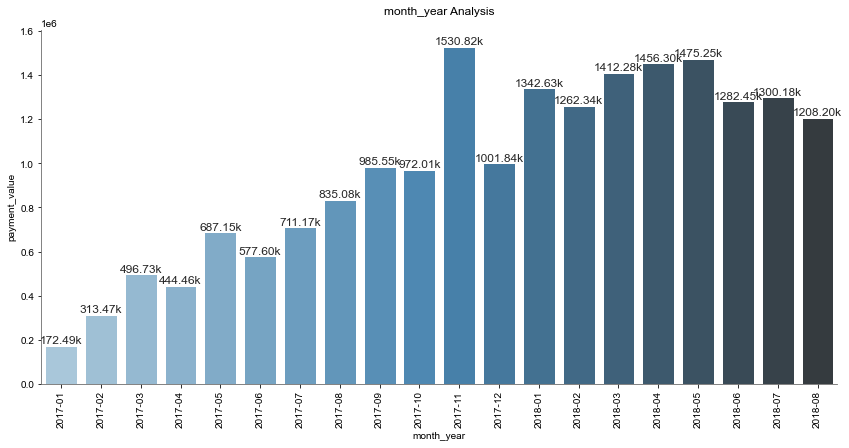

In [36]:
fig, ax = plt.subplots(figsize = (12,6))
sns.set(palette = 'muted', color_codes = True, style='whitegrid')
bar_plot(x = 'month_year', y = 'payment_value', df = df_revenue, value = True)
ax.tick_params(axis = 'x', labelrotation = 90)
plt.show()

### Sales by Day

In [37]:
df_day = df.groupby(['order_purchase_day'])['payment_value'].sum().reset_index()
df_day

,order_purchase_day,payment_value
0,Fri,2906012.45
1,Mon,3174421.80
2,Sat,2056448.69
3,Sun,2172082.71
4,Thu,2949013.80
5,Tue,3182104.82
6,Wed,3027903.72


In [38]:
# 값 정렬하기 
from pandas.api.types import CategoricalDtype
cats = ['Mon','Tue','Wed','Thu','Fri','Sat','Sun']
df_day['order_purchase_day'] = pd.Categorical(df_day['order_purchase_day'], categories = cats, ordered = True)
df_day = df_day.sort_values('order_purchase_day')

df_day

,order_purchase_day,payment_value
1,Mon,3174421.80
5,Tue,3182104.82
6,Wed,3027903.72
4,Thu,2949013.80
0,Fri,2906012.45
2,Sat,2056448.69
3,Sun,2172082.71


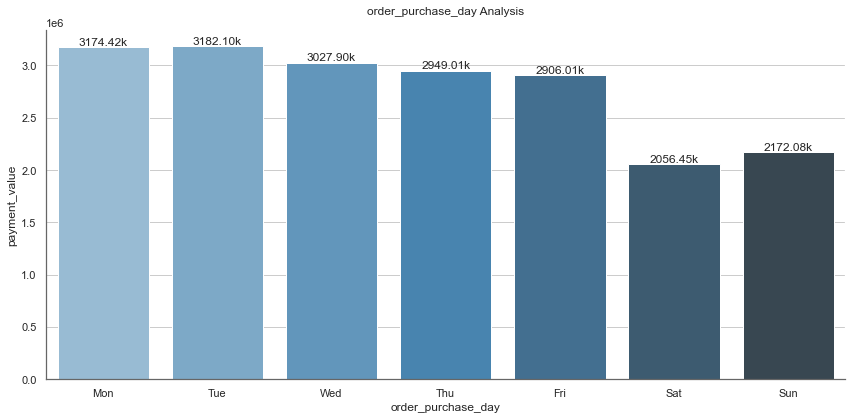

In [39]:
fig, ax = plt.subplots(figsize = (12,6))
sns.set(palette = 'muted', color_codes = True, style='whitegrid')
bar_plot(x = 'order_purchase_day', y = 'payment_value', df = df_day, value = True)
ax.tick_params(axis = 'x')
plt.show()

### Sales by hour

In [40]:
df_hour = df.groupby(['order_purchase_hour'])['payment_value'].sum().reset_index()
df_hour

,order_purchase_hour,payment_value
0,0,448620.43
1,1,200295.03
2,2,88932.78
3,3,45398.48
4,4,35176.65
5,5,28480.56
6,6,76066.24
7,7,208139.14
8,8,575785.46
9,9,1041500.56


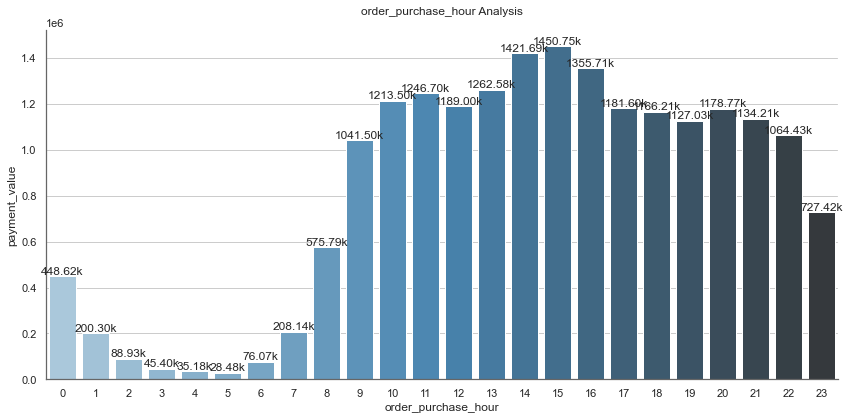

In [41]:
fig, ax = plt.subplots(figsize = (12,6))
sns.set(palette = 'muted', color_codes = True, style='whitegrid')
bar_plot(x = 'order_purchase_hour', y = 'payment_value', df = df_hour, value = True)
ax.tick_params(axis = 'x')
plt.show()

## Monthly Active Customers 

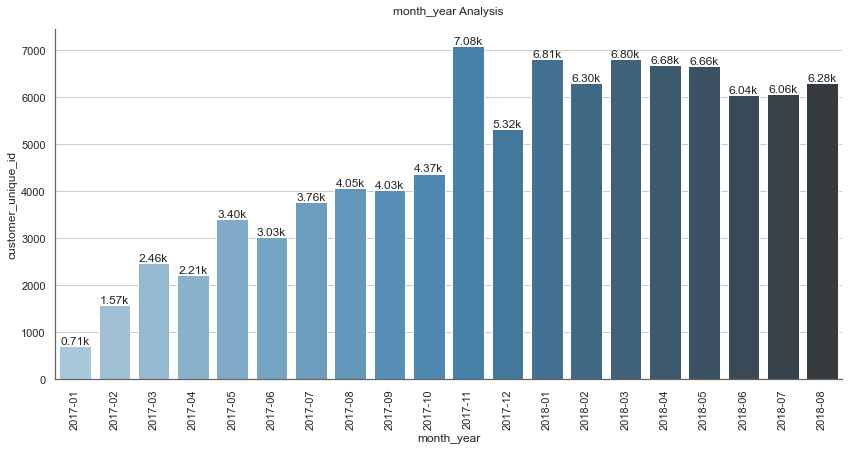

In [42]:
# creating monthly active customers dataframe by counting unique Customer IDs
df_monthly_active = df.groupby('month_year')['customer_unique_id'].nunique().reset_index()

fig, ax = plt.subplots(figsize=(12, 6))
sns.set(palette='muted', color_codes=True, style='whitegrid')
bar_plot(x='month_year', y='customer_unique_id', df=df_monthly_active, value=True)
ax.tick_params(axis='x', labelrotation=90)
plt.show()

## Monthly Order Count 
* 주문 수는 점점 상향하는 추세이다. 
* 2017년 11월에 최고점을 찍었고, 12월에 소폭 하락했지만 이내 회복 추세에 들어감. 
    * 이러한 현상은 11월 블프 행사 때 상품을 대량 구매하여 나타난 상황이라 해석할 수 있기 때문에 문제 상황이라 보기는 어려울 것이다. 
    * 하지만 매출 또한 12월이 11월에 비해 떨어진 것은 분명하니 12월 매출 회복을 위한 프로모션이 필요하다.


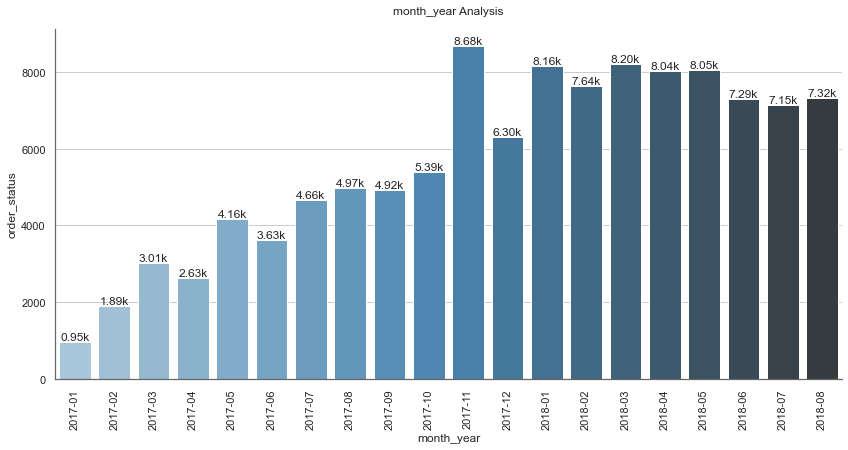

In [43]:
# creating monthly active customers dataframe by counting unique Customer IDs
df_monthly_sales = df.groupby('month_year')['order_status'].count().reset_index()

fig, ax = plt.subplots(figsize = (12,6)) # 그래프 fig size 설정 
sns.set(palette = 'muted', color_codes=True, style = 'whitegrid') 
bar_plot(x = 'month_year', y = 'order_status', df=df_monthly_sales, value = True)
ax.tick_params(axis='x', labelrotation=90) # x축 라벨 기울기 설정 
plt.show()

## Daily Order Count

In [44]:
df_daily_sales = df.groupby('order_purchase_day')['order_status'].count().reset_index()
df_daily_sales

,order_purchase_day,order_status
0,Fri,16140
1,Mon,18410
2,Sat,12200
3,Sun,13409
4,Thu,16871
5,Tue,18345
6,Wed,17680


In [45]:
# 값 정렬하기 
df_daily_sales['order_purchase_day'] = pd.Categorical(df_daily_sales['order_purchase_day'],categories = cats, ordered = True)
df_daily_sales = df_daily_sales.sort_values('order_purchase_day')

df_daily_sales

,order_purchase_day,order_status
1,Mon,18410
5,Tue,18345
6,Wed,17680
4,Thu,16871
0,Fri,16140
2,Sat,12200
3,Sun,13409


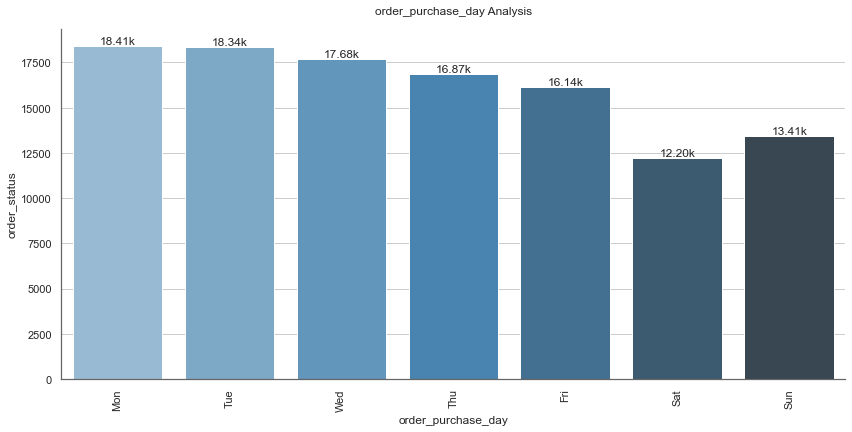

In [46]:
# 그래프 그리기 

fig, ax = plt.subplots(figsize = (12,6)) # 그래프 fig size 설정 
sns.set(palette = 'muted', color_codes=True, style = 'whitegrid') 
bar_plot(x = 'order_purchase_day', y = 'order_status', df=df_daily_sales, value = True)
ax.tick_params(axis='x', labelrotation=90) # x축 라벨 기울기 설정 
plt.show()

## Hour Order Count

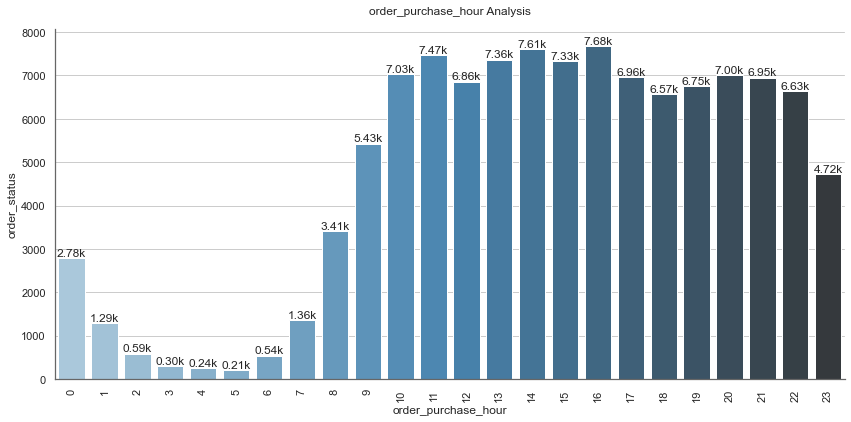

In [47]:
df_hour_sales = df.groupby('order_purchase_hour')['order_status'].count().reset_index()

fig, ax = plt.subplots(figsize = (12,6)) # 그래프 fig size 설정 
sns.set(palette = 'muted', color_codes=True, style = 'whitegrid') 
bar_plot(x = 'order_purchase_hour', y = 'order_status', df=df_hour_sales, value = True)
ax.tick_params(axis='x', labelrotation=90) # x축 라벨 기울기 설정 
plt.show()

## Average Revenue per Customer Purchase 
**분석 결과**
* 2017년 9월에 ARPPU가 가장 높게 나타났다. 

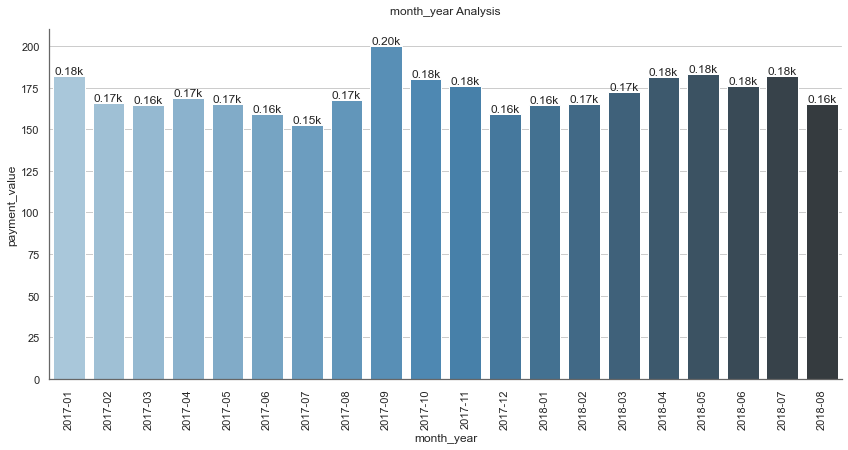

In [48]:
# create a new dataframe for average revenue by taking the mean of it 
df_monthly_order_avg = df.groupby('month_year')['payment_value'].mean().reset_index()

fig, ax = plt.subplots(figsize = (12,6))
sns.set(palette='muted',color_codes = True, style='whitegrid')
bar_plot(x = 'month_year', y = 'payment_value', df = df_monthly_order_avg, value = True)
ax.tick_params(axis = 'x', labelrotation=90)
plt.show()

In [49]:
df_monthly_order_avg

,month_year,payment_value
0,2017-01,181.948386
1,2017-02,165.594464
2,2017-03,164.808115
3,2017-04,168.931114
4,2017-05,165.099904
5,2017-06,159.204821
6,2017-07,152.775259
7,2017-08,167.888953
8,2017-09,200.193520
9,2017-10,180.469775


## 1인당 월 구매 횟수 -- 수확 없음
**분석결과**
* 1인당 월 구매 횟수는 약 1.2개로 나타났다. 
* 분기별로 살펴보았을 때도 약 1.2개로 동일했다.

In [71]:
x = df.groupby(['order_purchase_quarter','customer_unique_id'])['order_id'].count().reset_index()
x

,order_purchase_quarter,customer_unique_id,order_id
0,1,0000f46a3911fa3c0805444483337064,1
1,1,00053a61a98854899e70ed204dd4bafe,2
2,1,0005e1862207bf6ccc02e4228effd9a0,1
3,1,0005ef4cd20d2893f0d9fbd94d3c0d97,1
4,1,00090324bbad0e9342388303bb71ba0a,1
...,...,...,...
93073,4,ffe9be10b9a58c5464d833e8b1b2c632,1
93074,4,fff7219c86179ca6441b8f37823ba3d3,2
93075,4,fffa431dd3fcdefea4b1777d114144f2,1
93076,4,fffb09418989a0dbff854a28163e47c6,1


In [72]:
x = x.groupby('order_purchase_quarter')['order_id'].mean().reset_index()
x

,order_purchase_quarter,order_id
0,1,1.217366
1,2,1.214720
2,3,1.207480
3,4,1.220737


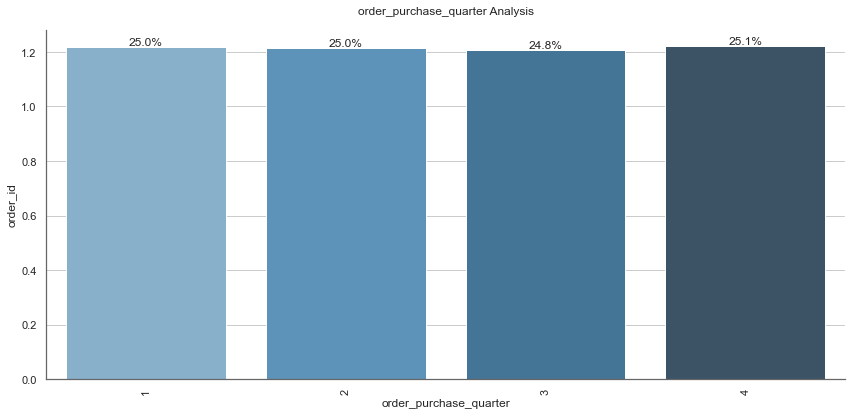

In [70]:
fig, ax = plt.subplots(figsize = (12,6))
sns.set(palette='muted',color_codes = True, style='whitegrid')
bar_plot(x = 'order_purchase_quarter', y = 'order_id', df = x, value = False)
ax.tick_params(axis = 'x', labelrotation=90)
plt.show()

## Average Order Value (AOV) -- 지우님? 

**AOV(평균 주문 가치)란?**
* 특정 기간 동안 한 건의 상품 주문이 발생할 때 가치(수익)을 의미 
* AOV = total revenue / number or orders
* AOV 최적화를 위해서는 구매 전환율이나 객단가를 상승시키기 위한 캠페인 진행이 필요

**분석 결과** 
* 2017년과 2018년 모두 2분기때의 AOV가 가장 높게 나타났다 (173, 180) 

In [108]:
aov_total  = df.groupby('month_year')['payment_value'].sum().reset_index()
aov_cnt  = df.groupby('month_year')['order_id'].count().reset_index()
aov_total['AOV'] = round(aov_total['payment_value']/aov_cnt['order_id'],2)
aov = aov_total[['month_year','AOV']]
aov

,month_year,AOV
0,2017-01,181.95
1,2017-02,165.59
2,2017-03,164.81
3,2017-04,168.93
4,2017-05,165.10
5,2017-06,159.20
6,2017-07,152.78
7,2017-08,167.89
8,2017-09,200.19
9,2017-10,180.47


In [145]:
df_monthly_order_avg

,month_year,payment_value
0,2017-01,181.948386
1,2017-02,165.594464
2,2017-03,164.808115
3,2017-04,168.931114
4,2017-05,165.099904
5,2017-06,159.204821
6,2017-07,152.775259
7,2017-08,167.888953
8,2017-09,200.193520
9,2017-10,180.469775


In [143]:
df['customer_id'].nunique()

94859

In [144]:
df['order_id'].nunique()

94859

In [141]:
aov_month_2017 = aov[0:12]
aov_month_2018 = aov[12:]

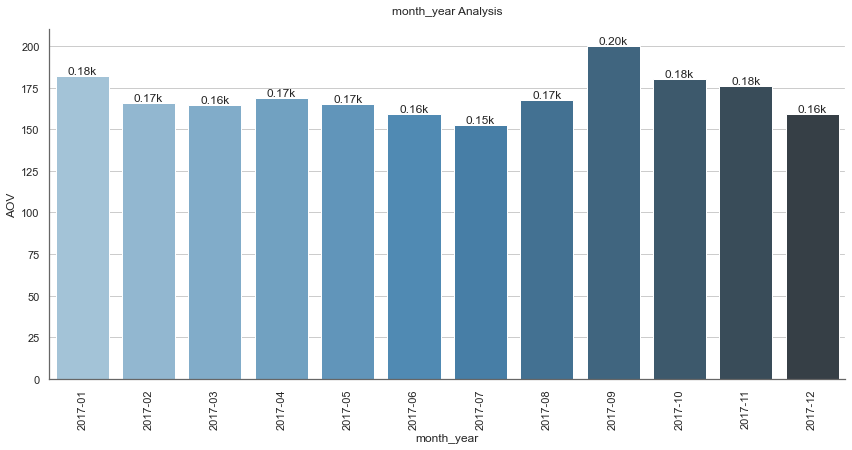

In [112]:
# aov_month_2017
fig, ax = plt.subplots(figsize = (12,6))
sns.set(palette='muted',color_codes = True, style='whitegrid')
bar_plot(x = 'month_year', y = 'AOV', df = aov_month_2017, value = True)
ax.tick_params(axis = 'x', labelrotation=90)
plt.show()

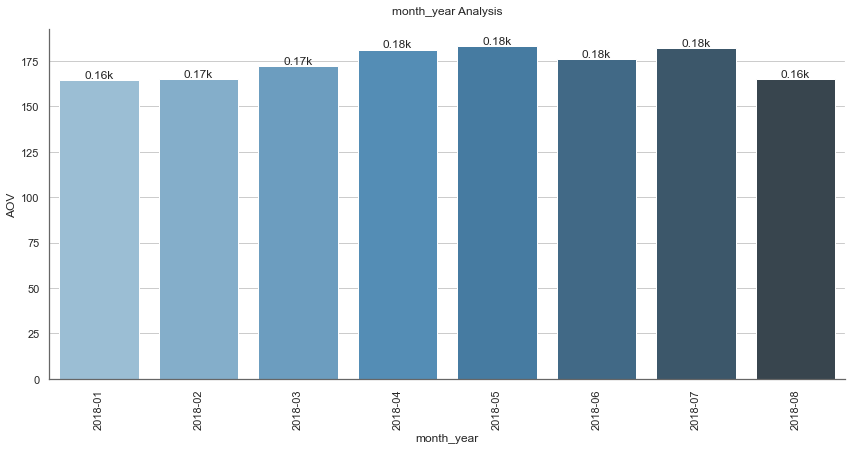

In [113]:
# aov_month_2018
fig, ax = plt.subplots(figsize = (12,6))
sns.set(palette='muted',color_codes = True, style='whitegrid')
bar_plot(x = 'month_year', y = 'AOV', df = aov_month_2018, value = True)
ax.tick_params(axis = 'x', labelrotation=90)
plt.show()

In [121]:
# 2017년 분기별 AOV 
aov_month_2017['month_year'] = pd.to_datetime(aov_month_2017['month_year'], format='%Y-%m')

In [123]:
aov_month_2017['month_year'] = aov_month_2017['month_year'].apply(lambda x : x.quarter)

In [126]:
aov_quarter_2017 = aov_month_2017.groupby('month_year')['AOV'].mean().reset_index()
aov_quarter_2017

,month_year,AOV
0,1,170.783333
1,2,164.410000
2,3,173.620000
3,4,171.940000


In [142]:
# 2018년 분기별 AOV 
aov_month_2018['month_year'] = pd.to_datetime(aov_month_2018['month_year'], format='%Y-%m')
aov_month_2018['month_year'] = aov_month_2018['month_year'].apply(lambda x : x.quarter)
aov_quarter_2018 = aov_month_2018.groupby('month_year')['AOV'].mean().reset_index()
aov_quarter_2018

,month_year,AOV
0,1,167.283333
1,2,180.093333
2,3,173.440000


In [97]:
# 전체분기로 살펴보자 

aov_quarter_total  = df.groupby('order_purchase_quarter')['payment_value'].sum().reset_index()
aov_quarter_cnt = df.groupby('order_purchase_quarter')['order_id'].count().reset_index()


In [105]:
aov_quarter_total['AOV'] = round(aov_quarter_total['payment_value']/aov_quarter_cnt['order_id'],2)
aov_quarter = aov_quarter_total[['order_purchase_quarter','AOV']]

aov_quarter

,order_purchase_quarter,AOV
0,1,167.43
1,2,175.23
2,3,173.66
3,4,172.07


## New Customer Ratio 

In [ ]:
# create a dataframe contaning CustomerID and first purchase date

df_min_purchase = df.groupby('customer_unique_id').order_purchase_timestamp.min().reset_index()
df_min_purchase.columns = ['customer_unique_id','minpurchasedate']
df_min_purchase['minpurchasedate'] = df_min_purchase['minpurchasedate'].map(lambda date: 100*date.year + date.month)

# merge first purchase date column to our main dataframe 
df = pd.merge(df, df_min_purchase, on = 'customer_unique_id')

In [ ]:
# create a colum called User Type and assign Existing 
# if User's First Purchase Year Month before the selected Invoice Year Month 
df['usertype'] = 'New'
df.loc[df['month_y'] > df['minpurchasedate'],'usertype'] = 'Existing'

# calculate the Revenue per month for each user type 
df_user_type_revenue = df.groupby(['month_y','usertype','month_year'])['payment_value'].sum().reset_index()

df_user_type_revenue

In [ ]:
fig, ax = plt.subplots(figsize = (15,6))
sns.set(palette = 'muted', color_codes = True)
ax = sns.lineplot(x = 'month_year', y = 'payment_value', data = df_user_type_revenue.query("usertype == 'New'"),label = 'New')
ax = sns.lineplot(x = 'month_year', y = 'payment_value', data = df_user_type_revenue.query("usertype == 'Existing'"),label = 'Existing')
format_spines(ax, right_border = False)
ax.set_title('Existing VS New Customer Comparison')
ax.tick_params(axis = 'x', labelrotation=90)
plt.show()

In [ ]:
df_user_type_cnt = df.groupby(['month_y','usertype','month_year'])['customer_unique_id'].count().reset_index()
df_user_type_cnt

In [ ]:
fig, ax = plt.subplots(figsize=(15, 6))
sns.set(palette='muted', color_codes=True)
ax = sns.lineplot(x='month_year', y='payment_value', data=df_user_type_revenue.query("usertype == 'New'"), label='New')
ax = sns.lineplot(x='month_year', y='payment_value', data=df_user_type_revenue.query("usertype == 'Existing'"), label='Existing')
format_spines(ax, right_border=False)
ax.set_title('Existing vs New Customer Comparison')
ax.tick_params(axis='x', labelrotation=90)
plt.show()

In [ ]:
fig,ax = plt.subplots(figsize = (15,5))
sns.set(palette = 'Paired', color_codes = True, style = 'whitegrid')

area01 = fig.add_subplot(1,2,1)
area02 = fig.add_subplot(1,2,2)

sns.barplot(x = 'month_year', y = 'customer_unique_id', data = df_user_type_cnt.query("usertype == 'New'"),ax = area01, label = 'New')
sns.barplot(x = 'month_year', y = 'customer_unique_id', data = df_user_type_cnt.query("usertype == 'Existing'"), ax = area02, label = 'Existing')
ax.tick_params(axis = 'x', labelrotation=90)

plt.show()

100% 누적 그래프로 다시 그려보기 

## New Customer Ratio

In [ ]:
# create a dataframe that shows new user ratio -- we also need to drop NA Valeus ()
df_user_ratio = df.query("usertype == 'New'").groupby(['month_year'])['customer_unique_id'].nunique()/df.query("usertype == 'Existing'").groupby(['month_year'])['customer_unique_id'].nunique()
df_user_ratio = df_user_ratio.reset_index()

# dropping nan values that resulted from frist and last month 
df_user_ratio = df_user_ratio.dropna()
df_user_ratio.columns = ['month_year','NewCusRatio']

# print the dataframe 
df_user_ratio

In [ ]:
fig, ax = plt.subplots(figsize = (12,6))
sns.set(palette = 'muted', color_codes = True, style = 'whitegrid')
bar_plot(x = 'month_year', y = 'NewCusRatio', df=df_user_ratio, value = True)
ax.tick_params(axis = 'x', labelrotation = 90)
plt.show()

## Monthly Retention Rate 

In [ ]:
# Monthly Retention Rate = Retained Customer From Prev. Month/Active Customer Total (using crosstab)

# identifying active users are active by looking at their revenue per month 
df_user_purchase = df.groupby(['customer_unique_id','month_y'])['payment_value'].sum().reset_index()
df_user_purchase.head()

In [ ]:
# identifying active users are active by looking at their order count per month
df_user_purchase = df.groupby(['customer_unique_id','month_y'])['payment_value'].count().reset_index()
df_user_purchase.head()

In [ ]:
#create retention matrix with crosstab using purchase
df_retention = pd.crosstab(df_user_purchase['customer_unique_id'], df_user_purchase['month_y']).reset_index()
df_retention.head()

In [ ]:
#creating an array of dictionary which keeps Retained & Total User count for each month
months = df_retention.columns[2:]
retention_array = []
for i in range(len(months)-1):
    retention_data = {}
    selected_month = months[i+1]
    prev_month = months[i]
    retention_data['month_y'] = int(selected_month)
    retention_data['TotalUserCount'] = df_retention[selected_month].sum()
    retention_data['RetainedUserCount'] = df_retention[(df_retention[selected_month]>0) & (df_retention[prev_month]>0)][selected_month].sum()
    retention_array.append(retention_data)
    
#convert the array to dataframe and calculate Retention Rate
df_retention = pd.DataFrame(retention_array)
df_retention['RetentionRate'] = df_retention['RetainedUserCount']/df_retention['TotalUserCount']

df_retention

In [ ]:
products.isna().sum()